# Tumor Analysis from CI5-Xd

---


This is an analysis of tumor incidence in 7 global regions (WHO regions, with America split into USA/Canada and Latin America) from data in the CI5-Xd database. The database can be downloaded here: http://ci5.iarc.fr/CI5-X/Pages/download.aspx (Use the detailed database.)

First, we'll need to import some libraries.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## Demographic data

We'll define a WHO standard population for the 18 age groups in the CI5 dataset. Ref: https://seer.cancer.gov/stdpopulations/world.who.html
We also use [WHO statistics](http://www.aho.afro.who.int/en/atlas/overview-and-introduction) to define total populations for each region. World Bank income groups were used from [2016](http://databank.worldbank.org/data/download/site-content/CLASS.xls). Populations of World Bank income group were taken from [2015](http://wdi.worldbank.org/table/2.1).

In [2]:
whoStandardPop = np.array([88569, 86870, 85970, 84670, 82171, 
                           79272, 76073, 71475, 65877, 60379,
                           53681, 45484, 37187, 29590, 22092, 
                           15195,  9097, (4398+1500+400+50), 0])/10  
                           # Add a 0 on the end for the 'Unknown' classification
                           # Standard population sums to 100,000
regionList = ['AFR   ', 'AMR-L ', 'AMR-US', 'EMR   ', 'WPR   ', 'SEAR  ', 'EUR   ']
regionPop = np.array([927371, 606019, 360476, 612580, 1857588, 1855068, 906996])*1000.
incomeList = ['LIC ', 'LMIC', 'HMIC', 'HIC ']
incomePop = np.array([638.3, 2927.4, 2593.7, 1187.2])*1000000.

## Loading the list of registries

Next, we'll define some locations where the data are. The registry list should be in CSV format, with a row for each registry. The columns list:

1. A numeric code denoting the identity of the registry, corresponding to the name of the CSV file with data from that registry.
2. A text description of the registry.
3. A numeric code listing which region the registry corresponds to: 
         1- AFR  2- AMR-L  3- AMR-US  4- EMR
         5- WPR  6- SEAR   7- EUR
4. A numeric code denoting the WorldBank income level of the country the registry covers:
        1- Low income            2- Lower middle income
        3- Higher middle income  4- High income
5. A numeric flag denoting whether to use the registry in the calculation. 
        0- Don't use. 1- Use.

In [3]:
dataDir = './CI5-Xd/CSV/'

# registryListCSV = './CI5-Xd/registryCSVtest.csv'  # For testing.
registryListCSV = './CI5-Xd/registryCSV.csv'

`registryCSVtest.csv` is an file for testing by evaluating only 1 registry in each region. This allows registry data to be compared with CI5 online analysis statistics and Miranda-Filho, et al. for QC checking of both the data handling and statistical analysis. Case counts and ASR are listed for male patients age 15-85+ from the CI5 online analysis. For comparison, set `useSexes = [1]` and `useTumors = [183, 184]` to capture all meningiomas and CNS tumors. Note that there will be some small differences in the calculated ASRs most likely because this analysis ignores captured tumors for which there is no matching population at-risk data.


|  Code  |  Registry         |  Cases | ASR  | 
|--------|-------------------|------------|---------|
| AFR    | Uganda            | 30  | 2.6         
| AMR-L  | Brazil, Goinia    | 214 | 13.3
| AMR-US | SEER 9, Black     | 248 | 4.4
| EMR    | Kuwait            | 98  | 2.6
| WPR    | New Zealand       | 729 | 7.9
| SEAR   | India, Barshi     | 15  | 1.7
| EUR    | Czech Republic    | 1953 | 7.8

Import the registry list as a DataFrame. Skip the 1st row, and add our own descriptions for the columns. We'll just display the first few registries from the list.

In [4]:
registryList = pd.read_csv(registryListCSV, skiprows=1, 
                           names=['RegN', 'Description', 'Region', 'Income', 'Use'])
registryList.iloc[1:5]

,RegN,Description,Region,Income,Use
1,14340199,"Libya, Benghazi (2003-2005)",1,3,1
2,14540199,"Malawi, Blantyre (2003-2007)",1,1,1
3,17100199,"South Africa, PROMEC (2003-2007)",1,3,1
4,17160270,"Zimbabwe, Harare: African (2003-2006)",1,1,1


## Choosing populations and tumor types to analyze

Now we need to define what age range and tumor types we'll use. 

Group codes are indexed 1-19, corresponding to ages 0-4, 5-9, 10-14, 15-19,..., 80-84, 85+, Unknown.

Sex is coded 1- male, 2- female.

Tumors are described in cancer.txt. Relevant codes are:

    173 Eye, brain and central nervous system (C69-72)
    174 Eye (C69)
    175 	Retinoblastoma
    176 	Melanoma
    177 	Squamous cell carcinoma
    178 	Other specified carcinoma
    179 	Unspecified carcinoma
    180 	Sarcoma
    181 	Other morphology
    182 	Unspecified morphology
    183 Meninges (C70)
    184 Central nervous system (C71-72)
    185 	Astrocytic tumours
    186 	Oligodendroglial tumours and mixed gliomas
    187 	Ependymal tumours
    188 	Gliomas of uncertain origin
    189 	Medulloblastoma
    190 	Other embryonal tumours
    191 	Other neuroepithelial tumours
    192 	Other specified morphology
    193 	Unspecified morphology
    194 Brain (C71)
    195 Other parts of central nervous system (C72)
    196 	Spinal cord, cauda equina (C72.0,1)
    197 	Cranial nerves (C72.2-5)
    198 	Nervous system, NOS (C72.8-9)

Listing any of these codes in the variable `useTumors` below will include them in the analysis. Similarly, the age groups and patient sexes used in the analysis can be restricted below.

In [5]:
ageList = [  '0-4' , '5-9', '10-14','15-19','20-24',
            '25-29','30-34','35-39','40-44','45-49',
            '50-54','55-59','60-64','65-69','70-74',
            '75-79','80-84','85+','Unknown']

useAges   = np.array([4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])  # Use ages 15-85+
useSexes  = [1,2]    # Use both male and female

# useTumors = [183, 184]  
# tumorDescription = 'All meningioma, brain, and spine tumors (C70, C71, C72)'
useTumors = [183, 194]  
tumorDescription = 'Meningioma and brain tumors (C70, C71)'
# useTumors = [195]
# tumorDescription = 'Spinal cord, cauda equina, cranial nerves (C72)'
# useTumors = [196]
# tumorDescription = 'Spinal cord and cauda equina tumors (C72.0-1)'

## Table for aggregating data

We create a table for aggregating summary data, and fill it with population figures.

In [6]:
sumTable = pd.DataFrame(index=np.arange(1,15),
                        columns=['Region','Population','Cases',
                                 'Person-Years','Crude Rate',
                                 'ASR','CI_L','CI_H','Registries'])  
sumTable['Region'] = regionList + incomeList + ['LIC/LMIC','HMIC/HIC','World']
sumTable.loc[1:7,('Population')] = regionPop
sumTable.loc[8:11,('Population')] = incomePop
sumTable.loc[12,('Population')] = sum(sumTable.loc[8:9,('Population')])
sumTable.loc[13,('Population')] = sum(sumTable.loc[10:11,('Population')])
sumTable.loc[14,('Population')] = sum(regionPop)

## Collecting data from each registry

Now for each region, we'll load the data from the CSV file for each registry and extract the records that meet our search critera based on age, sex, and tumor type, and store the data in a dict called: `regionData[]`. We'll also aggregate data into a second dict called `incomeData[]`.

In [7]:
# Make an empty dict to aggregate registry data for each region, 
# and each WorldBank Income zone.
regionData = dict()
incomeData = dict()

# Loop through all the regions we need to analyze...
for regionN in range(1, 8):
    
    # Initialize the dict with an empty dataframe for that region
    regionData[regionN] = pd.DataFrame()
    
    # Find the registries for this region that we want to use.
    regionRegs = registryList[np.logical_and(registryList['Region'] == regionN, registryList['Use'] > 0)]   
    Nregistries = len(regionRegs.index)
    print(str(regionN) + ': ' + regionList[regionN-1] + 
          ' - # Registries found: ' + str(Nregistries))
    
    # For each registry that we want to use...
    for row in regionRegs.itertuples():
        
        # Import the CSV file that corresponds to each registry.
        regDataFilename = dataDir + str(row.RegN) + '.csv'      
        try:
            regData = pd.read_csv(regDataFilename, skiprows=0, 
                                  names=['Sex', 'Cancer', 'Age', 'Cases', 'PersonYears'])

            # Select the data from that registry that meets our search criteria.
            sexOK    = np.in1d(regData['Sex'],useSexes)
            cancerOK = np.in1d(regData['Cancer'],useTumors)
            okData = regData[np.logical_and(sexOK, cancerOK)]

            # Aggregate it into a dataframe for the region.
            regionData[regionN] = pd.concat([regionData[regionN], okData])
        except:
            Nregistries = Nregistries - 1
            print('   Data missing: ' + regDataFilename + ', ' + row.Description)
            pass 

    sumTable.loc[regionN,('Registries')] = Nregistries
    
print(' ')        
        
# Do the same thing again, now looping through all the income strata we need to analyze...
for incomeN in range(1, 5):
    
    # Initialize the dict with an empty dataframe for that income zone
    incomeData[incomeN] = pd.DataFrame()
    
    # Find the registries for this income that we want to use.
    incomeRegs = registryList[np.logical_and(registryList['Income'] == incomeN, registryList['Use'] > 0)]   
    Nregistries = len(incomeRegs.index)
    print(str(incomeN) + ': ' + incomeList[incomeN-1] + ' - # Registries found: ' + str(Nregistries))
     
    # For each registry that we want to use...
    for row in incomeRegs.itertuples():
        
        # Import the CSV file that corresponds to each registry.
        regDataFilename = dataDir + str(row.RegN) + '.csv'
        
        try:
            regData = pd.read_csv(regDataFilename, skiprows=0, names=['Sex', 'Cancer', 'Age', 'Cases', 'PersonYears'])

            # Select the data from that registry that meets our search criteria.
            sexOK    = np.in1d(regData['Sex'],useSexes)
            cancerOK = np.in1d(regData['Cancer'],useTumors)
            okData = regData[np.logical_and(sexOK, cancerOK)]

            # Aggregate it into a dataframe for the region.
            incomeData[incomeN] = pd.concat([incomeData[incomeN], okData])
        except:
            Nregistries = Nregistries - 1
            print('   Data missing: ' + regDataFilename + ', ' + row.Description)
            pass 
        
    sumTable.loc[7 + incomeN,('Registries')] = Nregistries

1: AFR    - # Registries found: 8
2: AMR-L  - # Registries found: 25
3: AMR-US - # Registries found: 2
4: EMR    - # Registries found: 5
5: WPR    - # Registries found: 36
   Data missing: ./CI5-Xd/CSV/60360199.csv, Australian Capital Territory (2003-2007)
6: SEAR   - # Registries found: 18
7: EUR    - # Registries found: 114
 
1: LIC  - # Registries found: 3
2: LMIC - # Registries found: 17
3: HMIC - # Registries found: 52
4: HIC  - # Registries found: 136
   Data missing: ./CI5-Xd/CSV/60360199.csv, Australian Capital Territory (2003-2007)


## Analyzing population structure for each region

If we look at each of these regions, the population structures are pretty different. If we go through the data and calculate the fraction of each population in our collection of registries in each age bin, you can see that the AFR and EMR regions skew very young, and while AMR-US and EUR skew very old. The population structure of the WHO standard population is plotted as a dotted line for reference.

We can also plot the total person-years at risk in the sample. (Note the log-scale.) This gives a sense of the relative amount of surveillance captured by these datasets in the different regions. Note that some regions fall off steeply after the 75+ age groups. This is because some registries aggregate all ages over 75 into one age bin, so higher age bins are empty.

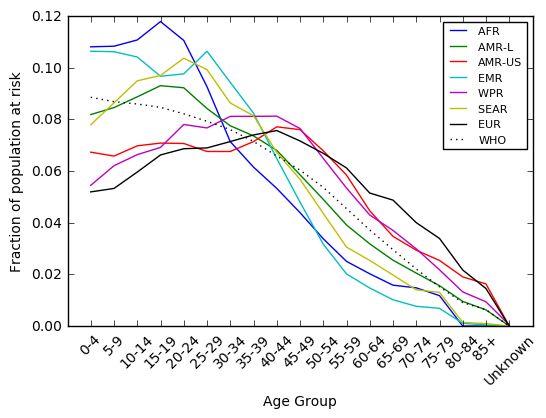

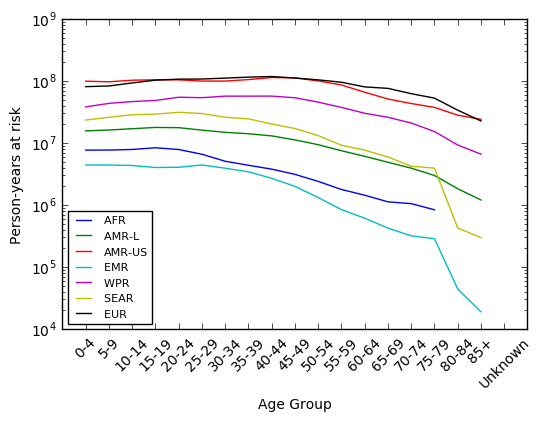

In [8]:
for regionN in range(1, 8):
    data = regionData[regionN]
    
    cases       = np.zeros(19)
    personYears = np.zeros(19)
    ageRate     = np.zeros(19)
    
    for ageN in np.arange(1,20):
        ageD = data[data['Age'] == ageN]
        cases[ageN-1]       = sum(ageD['Cases'])
        personYears[ageN-1] = sum(ageD['PersonYears'])/len(useTumors) # Don't double-count
        ageRate[ageN-1] = cases[ageN-1]/personYears[ageN-1]*100000
        
    plt.figure(1)
    plt.plot(np.arange(1,20), personYears/sum(personYears),'-',label=regionList[regionN-1]) 
    
    plt.figure(2)
    personYears[personYears < 10**4] = float('NaN') # Don't plot ages with very few person-years
    plt.plot(np.arange(1,19), personYears[0:18],'-',label=regionList[regionN-1])


plt.figure(1)
ax = plt.gca()
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Fraction of population at risk')    
plt.plot(np.arange(1,20), whoStandardPop/sum(whoStandardPop),'k:',label='WHO')
plt.legend(loc='upper right',prop={'size':8})

plt.figure(2)
ax = plt.gca()
ax.set_yscale('log')
plt.ylim(10**4,10**9)
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Person-years at risk')    
plt.legend(loc='lower left',prop={'size':8})


## Analyzing the age distribution of cases in each region

Looking at the number of cases recorded across age groups (normalized for the total number of cases, but not the population at risk) we can see the registries in all regions are filled with tumors of middle-aged people, with an upswing in some populations of pediatric tumors.

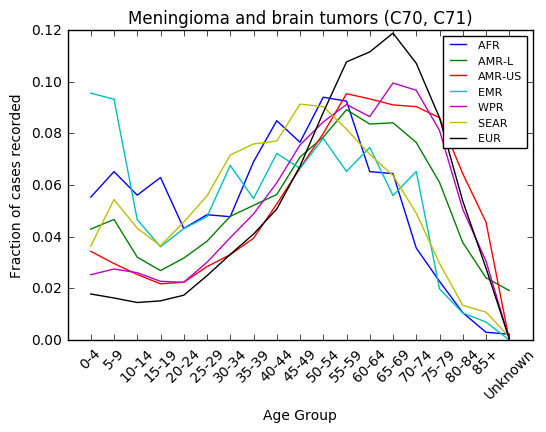

In [9]:
for regionN in range(1, 8):
    data = regionData[regionN]
    
    cases       = np.zeros(19)
    personYears = np.zeros(19)
    ageRate     = np.zeros(19)
    
    for ageN in np.arange(1,20):
        ageD = data[data['Age'] == ageN]
        cases[ageN-1]       = sum(ageD['Cases'])
        personYears[ageN-1] = sum(ageD['PersonYears'])/len(useTumors) # Don't double-count
        ageRate[ageN-1] = cases[ageN-1]/personYears[ageN-1]*100000 
    
    plt.figure(2)
    plt.plot(np.arange(1,20), cases[np.arange(1,20)-1]/sum(cases),'-',label=regionList[regionN-1])   

ax = plt.gca()
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Fraction of cases recorded')
plt.legend(loc='upper right',prop={'size':8})
plt.title(tumorDescription)

## Algorithm for calculating Age Standardized Rates (ASRs)

To compare regions with different population structures, for each region we need to calculate age-standardized rates (ASRs), and confidence intervals. Note that this estimate is weighted to account for differences in population structure, but not to account for differences in data coverage in each age group. We do this after *(Boyle 1991)*: 

   [Boyle, P., and D. M. Parkin. "Statistical methods for registries." *Cancer registration: principles and methods* 95 (1991): 126-158.](http://www.iarc.fr/en/publications/pdfs-online/epi/sp95/sp95-chap11.pdf)

We calculate truncated age standardized rates over the age-group indices in `useAges`. Where $n_{i}$ is the number of cases for age-group $i$, $y_{i}$ is the number of person-years at risk for age-group $i$, and $w_{i}$ is the world standard population for age-group $i$, the truncated age standardized rate per 100,000 population is:

$$ASR_t = \frac{\sum_{i}^{useAges}n_{i}w_{i}/y_{i}}{\sum_{i}^{useAges}w_{i}} * 100,000 $$

To calculate confidence intervals, we consider incidence as a Poisson process, so the variance is equal to the mean rate. Variance of the component age groups will add geometrically, so the standard error is:

$$S.E.(ASR_t) = \sqrt{\sum_{i}^{useAges}(\frac{w_i}{\sum_{j}^{useAges}w_j})^{2}(\frac{n_{i}}{y_{i}^{2}})}*100,000 $$

The 95% confidence intervals are approximated as:

$$ ASR_t \pm 1.96 * S.E.(ASR_t) $$

An alternative strategy using 10,000 bootstrap samples from a binomial distribution is also presented, and gives identical results.

Functions to implement these are given below, including testing datasets drawn from *Boyle*.

In [10]:
# Functions to calculate the ASR and SE of the ASR, test data below
# -----------------------------------------------------------------
# n: number of cases, y: number of person years, w: standard pop, 
# useAges: age indices to use.

# Calculate the age standardized rate (ASR).
def calculateASR(n, y, w, useAges):
    # If there's missing population data (y = 0) then don't use those ages.
    ageIX = np.in1d(np.arange(1,20),useAges)
    ageIX[y < 1] = 0
    
    ASR = sum(n[ageIX]*w[ageIX]/y[ageIX])/sum(w[ageIX])*100000
    return ASR

# Calculate approximate 95% confidence intervals on the ASR.
def calculateASRSE(n, y, w, useAges):
    # If there's missing population data (y = 0) then don't use those ages.
    ageIX = np.in1d(np.arange(1,20),useAges)
    ageIX[y < 1] = 0
    
    totUsePop = sum(w[ageIX])
    varASR = sum((w[ageIX]/totUsePop)**2 * (n[ageIX]/(y[ageIX]**2)))
    seASR = math.sqrt(varASR)*100000
    return seASR

# Calculate 95% confidence intervals on the ASR by bootstrapping from a 
# binomial distribution.
def bootstrapASRCI(n, y, w, useAges):
    # If there's missing population data (y = 0) then don't use those ages.
    ageIX = np.in1d(np.arange(1,20),useAges)
    ageIX[y < 1] = 0
    goodUseAges = ageIX.ravel().nonzero()
    
    nBoots = 10000
    bootN = np.zeros((19,nBoots))
    bootW = np.outer(w.transpose(), np.ones((1,nBoots)))
    bootY = np.outer(y.transpose(), np.ones((1,nBoots)))
    for ix in np.nditer(goodUseAges):
        bootN[ix,:] = np.random.binomial(y[ix],n[ix]/y[ix],nBoots)
    
    bootASR = (bootN[ageIX,:]*bootW[ageIX,:]/bootY[ageIX,:]).sum(axis=0) \
                     / bootW[ageIX,:].sum(axis=0)*100000
    bootASR = np.sort(bootASR)
    ixL = round(.025*nBoots)
    ixH = round(.975*nBoots)
    return bootASR[ixL], bootASR[ixH]

### Testing the ASR functions

Test data from *Boyle*, Example 3, ASR should equal 124.98

In [11]:
tuseAges = np.arange(8,14)
tn = np.array([0,0,0,0,0,0,0,7.48, 21.12,53.2,128.16,263.17,422.49,
           0,0,0,0,0,0])
tw = np.array([0,0,0,0,0,0,0,6000,6000,6000,5000,4000,4000,
     0,0,0,0,0,0])
ty = np.array([0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0])*100000
print("%.2f" % calculateASR(tn, ty, tw, tuseAges))

124.98


Test data from *Boyle*, Example 5. S.E. of ASR should equal 0.73

In [12]:
tuseAges = np.arange(1,20)
tw = np.array([ 12000, 10000, 9000, 9000, 8000,
                8000,  6000, 6000, 6000, 6000,
                5000,  4000, 4000, 3000, 2000,
                1000,   500,  500,    0])
ty = np.array([827400, 856500, 1061500, 1157400, 1074900,
              917700, 890300,  816000,  724400,  706800,
              703800, 691200,  610900,  511800,  425600,
              266800, 122500,   54700,      0])
ta = np.array([0, 0, 0, 0, 0.37,
              0.33, 3.26, 7.48, 21.12, 53.2,
              128.16, 263.17, 422.49, 600.04, 780.55,
              919.04, 981.22, 784.28, 0])
tn = ta*ty/100000
ASR   = calculateASR(tn, ty, tw, tuseAges)
ASRse = calculateASRSE(tn, ty, tw, tuseAges)
print("ASR: %.2f" % ASR)
print("ASRse %.2f" % ASRse)
print("ASRci     [%.2f, %.2f]" % (ASR-ASRse*1.96, ASR+ASRse*1.96))
ciL, ciH = bootstrapASRCI(tn, ty, tw, tuseAges)
print("ASRbootCI [%.2f, %.2f]" % (ciL, ciH))

ASR: 90.62
ASRse 0.73
ASRci     [89.20, 92.05]
ASRbootCI [89.21, 92.06]


## Calculating the ASR for each region

Now we'll go through each region to calculate the ASR. We'll also plot the raw age-specific rates for each region, which divides out differences in population structure to give use case rates for each age. 

We also construct a world-wide curve of age-specific rates, weighting each region curve by the region population.

Meningioma and brain tumors (C70, C71)
----------------------------------------
1: AFR   
	 ASR:   2.81 [2.63, 2.98]
	 # Cases: 1061
	 # Person-years: 47938310
	 Crude rate: 2.21
2: AMR-L 
	 ASR:   5.24 [5.12, 5.36]
	 # Cases: 7084
	 # Person-years: 143090633
	 Crude rate: 4.95
3: AMR-US
	 ASR:   6.45 [6.41, 6.50]
	 # Cases: 89095
	 # Person-years: 1179706716
	 Crude rate: 7.55
4: EMR   
	 ASR:   3.62 [3.29, 3.97]
	 # Cases: 648
	 # Person-years: 28505502
	 Crude rate: 2.27
5: WPR   
	 ASR:   4.11 [4.06, 4.16]
	 # Cases: 26007
	 # Person-years: 574954786
	 Crude rate: 4.52
6: SEAR  
	 ASR:   3.26 [3.17, 3.35]
	 # Cases: 6109
	 # Person-years: 223747283
	 Crude rate: 2.73
7: EUR   
	 ASR:   6.73 [6.68, 6.77]
	 # Cases: 108478
	 # Person-years: 1306491137
	 Crude rate: 8.30


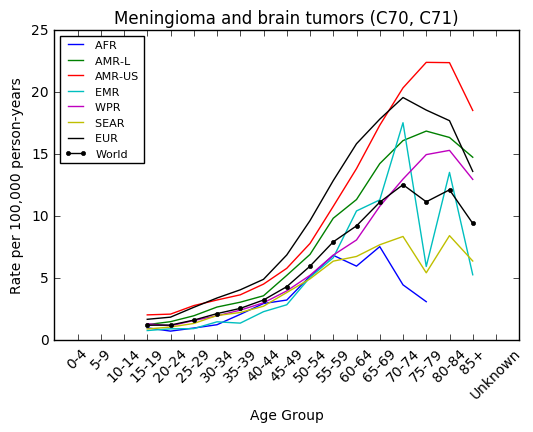

In [13]:
wAgeRate     = np.zeros(19)

print(tumorDescription)
print('----------------------------------------')

for regionN in range(1, 8):
    print(str(regionN) + ': '+ regionList[regionN-1])
    data = regionData[regionN]
    
    cases       = np.zeros(19)
    personYears = np.zeros(19)
    ageRate     = np.zeros(19)
    
    for ageN in np.arange(1,20):
        # Only take records that have PersonYears > 0
        ageD = data[np.logical_and(data['Age'] == ageN,data['PersonYears'] > 0)]
        cases[ageN-1]       = sum(ageD['Cases'])
        # Don't multiple-count person-years at risk when we're counting multiple tumors!
        personYears[ageN-1] = sum(ageD['PersonYears'])/len(useTumors) 
        ageRate[ageN-1] = cases[ageN-1]/personYears[ageN-1]*100000
   
    # Accumulate weighted ageRate for a world-wide aggregate
    # Protect against accumulating NaN
    popFract = sumTable.loc[regionN,('Population')] / sumTable.loc[14,('Population')]
    tAges = np.nonzero(np.logical_not(np.isnan(ageRate)))[0] 
    wAgeRate[tAges] = wAgeRate[tAges] + ageRate[tAges] * popFract

    ASR = calculateASR(cases, personYears, whoStandardPop, useAges)
    ASRciL, ASRciH = bootstrapASRCI(cases, personYears, whoStandardPop, useAges)
    crudeRate = sum(cases[useAges-1])/sum(personYears[useAges-1])*100000
    tPersonYears = sum(personYears[useAges-1])
    tCases = sum(cases[useAges-1])

    sumTable.loc[regionN,('ASR')] = ASR
    sumTable.loc[regionN,('CI_L')] = ASRciL
    sumTable.loc[regionN,('CI_H')] = ASRciH
    sumTable.loc[regionN,('Person-Years')] = tPersonYears
    sumTable.loc[regionN,('Crude Rate')] = crudeRate
    sumTable.loc[regionN,('Cases')] = tCases
    
    print("\t ASR:   %.2f [%.2f, %.2f]" % (ASR, ASRciL, ASRciH))
    print("\t # Cases: %d" % tCases)
    print("\t # Person-years: %d" % tPersonYears)
    print("\t Crude rate: %.2f" % crudeRate)

    plt.figure(3)
    plt.plot(useAges, ageRate[useAges-1],'-',label=regionList[regionN-1])   

plt.figure(3)
plt.plot(useAges, wAgeRate[useAges-1],'k.-',label='World') 
ax = plt.gca()
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
# plt.ylim(0,13)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Rate per 100,000 person-years')
plt.legend(loc='upper left',prop={'size':8})
plt.title(tumorDescription)

## Analyzing population structure for each income group

Returning to the income groups, we can similarly plot the population structures for those:

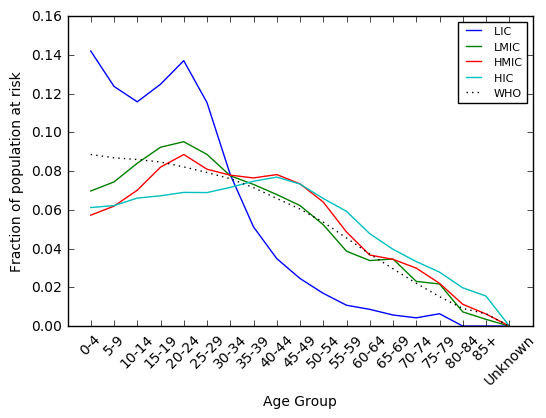

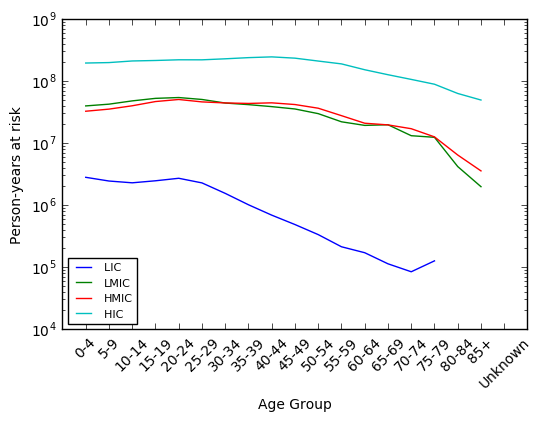

In [14]:
for incomeN in range(1, 5):
    data = incomeData[incomeN]
    
    cases       = np.zeros(19)
    personYears = np.zeros(19)
    ageRate     = np.zeros(19)
    
    for ageN in np.arange(1,20):
        ageD = data[data['Age'] == ageN]
        cases[ageN-1]       = sum(ageD['Cases'])
        # Don't multiple-count person-years at risk when we're counting multiple tumors!
        personYears[ageN-1] = sum(ageD['PersonYears'])/len(useTumors) 
        ageRate[ageN-1] = cases[ageN-1]/personYears[ageN-1]*100000
        
    plt.figure(1)
    plt.plot(np.arange(1,20), personYears/sum(personYears),'-',label=incomeList[incomeN-1]) 
    
    plt.figure(2)
    personYears[personYears < 10**4] = float('NaN')
    plt.plot(np.arange(1,19), personYears[0:18],'-',label=incomeList[incomeN-1])


plt.figure(1)
ax = plt.gca()
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Fraction of population at risk')    
plt.plot(np.arange(1,20), whoStandardPop/sum(whoStandardPop),'k:',label='WHO')
plt.legend(loc='upper right',prop={'size':8})

plt.figure(2)
ax = plt.gca()
ax.set_yscale('log')
plt.ylim(10**4,10**9)
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Person-years at risk')    
plt.legend(loc='lower left',prop={'size':8})

Lower income groups have a younger population structure, and less data available for estimates. 

## Calculating ASR for each income group

We can also calculate ASRs for each income group:

Meningioma and brain tumors (C70, C71)
----------------------------------------
1: LIC 
	 ASR:   1.41 [1.07, 1.80]
	 # Cases: 86
	 # Person-years: 12219916
	 Crude rate: 0.70
2: LMIC
	 ASR:   4.08 [4.02, 4.14]
	 # Cases: 17382
	 # Person-years: 440212180
	 Crude rate: 3.95
3: HMIC
	 ASR:   5.43 [5.36, 5.49]
	 # Cases: 26201
	 # Person-years: 462163510
	 Crude rate: 5.67
4: HIC 
	 ASR:   6.26 [6.23, 6.29]
	 # Cases: 194813
	 # Person-years: 2589838761
	 Crude rate: 7.52


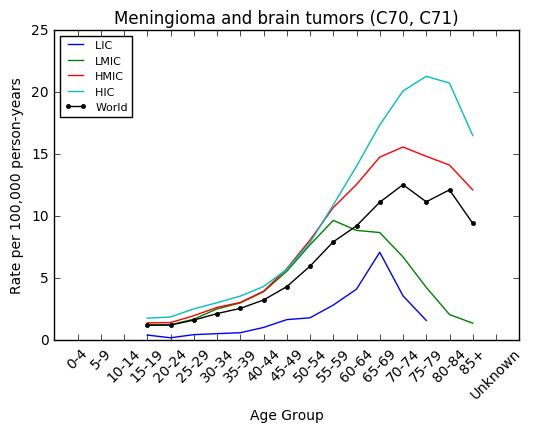

In [15]:
print(tumorDescription)
print('----------------------------------------')

for incomeN in range(1, 5):
    print(str(incomeN) + ': '+ incomeList[incomeN-1])
    data = incomeData[incomeN]
    
    cases       = np.zeros(19)
    personYears = np.zeros(19)
    ageRate     = np.zeros(19)
    
    for ageN in np.arange(1,20):
        # Only take records that have PersonYears > 0
        ageD = data[np.logical_and(data['Age'] == ageN,data['PersonYears'] > 0)]
        cases[ageN-1]       = sum(ageD['Cases'])
        # Don't multiple-count person-years at risk when we're counting multiple tumors!
        personYears[ageN-1] = sum(ageD['PersonYears'])/len(useTumors) 
        ageRate[ageN-1] = cases[ageN-1]/personYears[ageN-1]*100000
   
    ASR   = calculateASR(cases, personYears, whoStandardPop, useAges)
    ASRciL, ASRciH = bootstrapASRCI(cases, personYears, whoStandardPop, useAges)
    crudeRate = sum(cases[useAges-1])/sum(personYears[useAges-1])*100000
    tPersonYears = sum(personYears[useAges-1])
    tCases = sum(cases[useAges-1])

    sumTable.loc[7 + incomeN,('ASR')] = ASR
    sumTable.loc[7 + incomeN,('CI_L')] = ASRciL
    sumTable.loc[7 + incomeN,('CI_H')] = ASRciH
    sumTable.loc[7 + incomeN,('Person-Years')] = tPersonYears
    sumTable.loc[7 + incomeN,('Crude Rate')] = crudeRate
    sumTable.loc[7 + incomeN,('Cases')] = tCases
    
    print("\t ASR:   %.2f [%.2f, %.2f]" % (ASR, ASRciL, ASRciH))
    print("\t # Cases: %d" % tCases)
    print("\t # Person-years: %d" % tPersonYears)
    print("\t Crude rate: %.2f" % crudeRate)

    plt.figure(3)
    plt.plot(useAges, ageRate[useAges-1],'-',label=incomeList[incomeN-1])  

plt.figure(3)
plt.plot(useAges, wAgeRate[useAges-1],'k.-',label='World') 
ax = plt.gca()
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Rate per 100,000 person-years')
plt.legend(loc='upper left',prop={'size':8})
plt.title(tumorDescription)

High income groups show greater incidence of these tumors.

## Calculating ASR for two income groups

Because sampling of the low income countries is so poor, it probably makes sense to group LIC with LMIC, and HIC with HMIC to create two groups. Note that these estimates don't remove sampling effects - LIC/LMIC estimates look like LMIC because more registries we included are in LMIC, not because the population is. Also, note that the world-wide estimate is smaller than both of these two income groups. This is because it more faithfully reflects the population of LIC regions which have large populations, but are relatively undersampled and get washed out when pooled with LMIC countries.

Meningioma and brain tumors (C70, C71)
----------------------------------------
1: LIC/LMIC
	 ASR:   4.03 [3.97, 4.09]
	 # Cases: 17468
	 # Person-years: 452432096
	 Crude rate: 3.86
2: HMIC/HIC
	 ASR:   6.15 [6.12, 6.18]
	 # Cases: 221014
	 # Person-years: 3052002271
	 Crude rate: 7.24


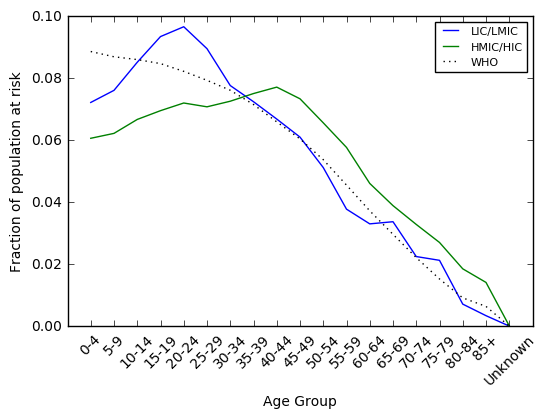

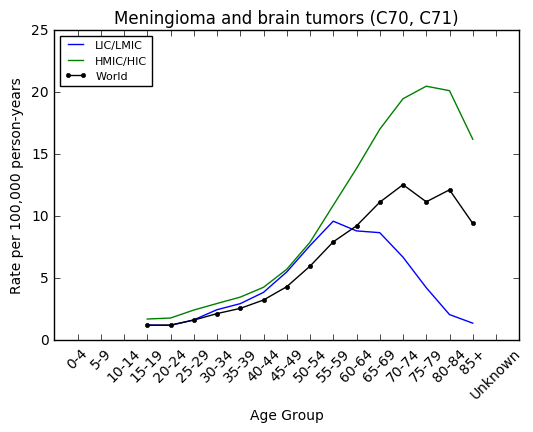

In [16]:
# Concatenate the 4-group income data into a DataFrame of 2 income groups.
incomeData2 = dict()
incomeData2[1] = pd.concat([incomeData[1],incomeData[2]])
incomeData2[2] = pd.concat([incomeData[3],incomeData[4]])
incomeList2 = ['LIC/LMIC', 'HMIC/HIC']

print(tumorDescription)
print('----------------------------------------')

for incomeN in range(1, 3):
    print(str(incomeN) + ': '+ incomeList2[incomeN-1])
    data = incomeData2[incomeN]
    
    cases       = np.zeros(19)
    personYears = np.zeros(19)
    ageRate     = np.zeros(19)
    
    for ageN in np.arange(1,20):
        # Only take records that have PersonYears > 0
        ageD = data[np.logical_and(data['Age'] == ageN,data['PersonYears'] > 0)]
        cases[ageN-1]       = sum(ageD['Cases'])
        # Don't multiple-count person-years at risk when we're counting multiple tumors!
        personYears[ageN-1] = sum(ageD['PersonYears'])/len(useTumors)
        ageRate[ageN-1] = cases[ageN-1]/personYears[ageN-1]*100000
   
    ASR   = calculateASR(cases, personYears, whoStandardPop, useAges)
    ASRciL, ASRciH = bootstrapASRCI(cases, personYears, whoStandardPop, useAges)
    crudeRate = sum(cases[useAges-1])/sum(personYears[useAges-1])*100000
    tPersonYears = sum(personYears[useAges-1])
    tCases = sum(cases[useAges-1])

    sumTable.loc[11 + incomeN,('ASR')] = ASR
    sumTable.loc[11 + incomeN,('CI_L')] = ASRciL
    sumTable.loc[11 + incomeN,('CI_H')] = ASRciH
    sumTable.loc[11 + incomeN,('Person-Years')] = tPersonYears
    sumTable.loc[11 + incomeN,('Crude Rate')] = crudeRate
    sumTable.loc[11 + incomeN,('Cases')] = tCases
    
    print("\t ASR:   %.2f [%.2f, %.2f]" % (ASR, ASRciL, ASRciH))
    print("\t # Cases: %d" % tCases)
    print("\t # Person-years: %d" % tPersonYears)
    print("\t Crude rate: %.2f" % crudeRate)
    
    plt.figure(1)
    plt.plot(np.arange(1,20), personYears/sum(personYears),'-',label=incomeList2[incomeN-1]) 

    plt.figure(3)
    plt.plot(useAges, ageRate[useAges-1],'-',label=incomeList2[incomeN-1])   
    
plt.figure(1)
ax = plt.gca()
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Fraction of population at risk')    
plt.plot(np.arange(1,20), whoStandardPop/sum(whoStandardPop),'k:',label='WHO')
plt.legend(loc='upper right',prop={'size':8})
    
plt.figure(3)  
plt.plot(useAges, wAgeRate[useAges-1],'k.-',label='World') 
ax = plt.gca()
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Rate per 100,000 person-years')
plt.legend(loc='upper left',prop={'size':8})
plt.title(tumorDescription)

# Sum the number of registries for the 2 income groups    
sumTable.loc[12,('Registries')] = sumTable.loc[8,('Registries')]+sumTable.loc[9,('Registries')]
sumTable.loc[13,('Registries')] = sumTable.loc[10,('Registries')]+sumTable.loc[11,('Registries')]

## Estimating world-wide tumor incidence

We can estimate the world-wide incidence of tumors by scaling our estimate for each region by the region population. To get confidence intervals we bootstrap, modelling each of the component region ASRs as a binomial process. For each bootstrap sample we get an ASR for each region, and combine them weighted by their region rates.

In [17]:
# Calculate the worldASR as a average of ASRs weighted by region population
worldASR = sum(sumTable.loc[1:7,('ASR')] * sumTable.loc[1:7,('Population')]) \
                            / sum(sumTable.loc[1:7,('Population')]) 

# Find confidence intervals by bootstrapping
nBoots = 10000
bootN = np.zeros((7, nBoots))
w = sumTable.loc[1:7,('Population')]
y = sumTable.loc[1:7,('Person-Years')]
bootW = np.outer(w.transpose(), np.ones((1,nBoots)))
bootY = np.outer(y.transpose(), np.ones((1,nBoots)))
# For each region, calculate bootstrap samples modeling tumor occurrence
for regionN in np.arange(1,8):
    personYears = sumTable.loc[regionN,('Person-Years')]
    ASR         = sumTable.loc[regionN,('ASR')]
    bootN[regionN-1,:] = np.random.binomial(personYears, ASR/100000, nBoots)

# Then recalculate the average ASR weighted by region population for each bootstrap
bootASR = (bootN*bootW/bootY).sum(axis=0) / bootW.sum(axis=0) * 100000
bootASR = np.sort(bootASR)
ixL = round(.025*nBoots)
ixH = round(.975*nBoots)   
CI_L = bootASR[ixL]
CI_H = bootASR[ixH]

sumTable.loc[14,('Cases')] = sum(sumTable.loc[1:7,('Cases')])
sumTable.loc[14,('Person-Years')] = sum(sumTable.loc[1:7,('Person-Years')])
sumTable.loc[14,('Crude Rate')] = sumTable.loc[14,('Cases')] \
                                 / sumTable.loc[14,('Person-Years')] * 100000
sumTable.loc[14,('ASR')] = worldASR
sumTable.loc[14,('CI_L')] = CI_L
sumTable.loc[14,('CI_H')] = CI_H
sumTable.loc[14,('Registries')] = sum(sumTable.loc[1:7,('Registries')])

print("World ASR: %.2f [%.2f, %.2f]" % (worldASR, CI_L, CI_H))

World ASR: 4.22 [4.19, 4.26]


## Summary data for malignant tumors

This fills out our summary data for malignant tumors. The table is:

In [18]:
print(tumorDescription)
sumTable

Meningioma and brain tumors (C70, C71)


,Region,Population,Cases,Person-Years,Crude Rate,ASR,CI_L,CI_H,Registries
1,AFR,9.27371e+08,1061,4.79383e+07,2.21326,2.80598,2.63052,2.98034,8
2,AMR-L,6.06019e+08,7084,1.43091e+08,4.95071,5.23733,5.11829,5.36276,25
3,AMR-US,3.60476e+08,89095,1.17971e+09,7.5523,6.4508,6.40727,6.4951,2
4,EMR,6.1258e+08,648,2.85055e+07,2.27325,3.62171,3.29039,3.96623,5
5,WPR,1.85759e+09,26007,5.74955e+08,4.52331,4.11202,4.06206,4.16306,35
6,SEAR,1.85507e+09,6109,2.23747e+08,2.73031,3.25819,3.1666,3.3504,18
7,EUR,9.06996e+08,108478,1.30649e+09,8.303,6.72561,6.68476,6.76729,114
8,LIC,6.383e+08,86,1.22199e+07,0.703769,1.41431,1.06602,1.79899,3
9,LMIC,2.9274e+09,17382,4.40212e+08,3.94855,4.08272,4.0221,4.14335,17
10,HMIC,2.5937e+09,26201,4.62164e+08,5.66921,5.4282,5.36287,5.49312,52


## Estimating incidence of benign tumors

The CI5 dataset does not report on benign tumors captured in its component registries. A basic estimate of the incidence of benign CNS tumors can be performed by using the ratio of benign to malignant tumors in large databases that do report them.

The NCI SEER program reports a comparison of benign and malignant tumors in [Table 31.1](https://seer.cancer.gov/csr/1975_2013/browse_csr.php?sectionSEL=31&pageSEL=sect_31_table.01.html), capturing 71,273 benign tumors and 31,146 malignant tumors, giving ASRs (albeit adjusted to a US standard population) of 15.9 benign tumors per 100,000 person-years and 7.0 malignant tumors per 100,000 person-years. (This ASR is similar to our calculated rate of total malignant CNS tumors of 6.62 for the US and Canada.) This suggests a benign:malignant ratio of 2.27.

CBTRUS reports on a larger dataset that includes SEER, most recently reported at: [Ostrom, Quinn T., et al. "CBTRUS Statistical Report: Primary Brain and Other Central Nervous System Tumors Diagnosed in the United States in 2009–2013." Neuro-Oncology 18.suppl 5 (2016): v1-v75.](http://neuro-oncology.oxfordjournals.org.ezp-prod1.hul.harvard.edu/content/18/suppl_5/v1.short) This dataset captured 250,211 benign tumors and 117,906 malignant tumors over 5 years, calculating ASRs of 15.18 [15.12 - 15.25] and 7.18 [7.14 - 7.22], respectively. This suggests a benign:malignant ratio of 2.11.

### Estimating confidence intervals for rate ratios

Calculating confidence intervals for a ratio of rates is non-trivial, but as described in *Boyle* can be approximated as: 

$$ C.I.(\frac{ASR_1}{ASR_2}) = (\frac{ASR_1}{ASR_2})^{1 \pm Z_{\alpha/2}/X} $$

where

$$ X = \frac{(ASR_1 - ASR_2)}{\sqrt{s.e.(ASR_1)^2 + s.e.(ASR_2)^2}} $$

Calculating this out we can get 95% confidence intervals on the Benign:Malignant ratio:

In [19]:
ASR1   = 15.18
ASR2   =  7.18
seASR1 = (15.25 - 15.12)/(2*1.96)
seASR2 = ( 7.22 -  7.14)/(2*1.96)
X = (ASR1 - ASR2)/math.sqrt(seASR1**2 + seASR2**2)
UL = (ASR1/ASR2)**(1+1.96/X)
LL = (ASR1/ASR2)**(1-1.96/X)
print("Benign:Malignant = %.3f [%.3f, %.3f]" % (ASR1/ASR2, LL, UL))

Benign:Malignant = 2.114 [2.099, 2.129]


### Bootstrapped confidence intervals for rate ratios

If we want a more rigorous confidence interval on this ratio we can bootstrap one from binomial distributions. (We estimate the person-years of exposure from the ASRs and the number of tumors detected.) The bootstrapped CI on the ratio of ASRs is identical to the analytic estimate.

In [20]:
# Estimate the number of crude person-years at risk in the CBTRUS, 
# averaging estimates from benign and malignant tumors.
personYears = round(((250211/(ASR1/100000)) + (117906/(ASR2/100000)))/2)

# Simulate incidence as a binomial distribution, draw nBoots samples.
nBoots = 10000
benignRate    = np.random.binomial(personYears,(ASR1/100000),nBoots)/personYears*100000.
malignantRate = np.random.binomial(personYears,(ASR2/100000),nBoots)/personYears*100000.
ratioASR      = benignRate/malignantRate

benignRate    = np.sort(benignRate)
malignantRate = np.sort(malignantRate)
ratioASR      = np.sort(ratioASR)

# Find 95% confidence intervals from the sorted simulations
ixL = round(nBoots*0.025)
ixH = round(nBoots*0.975)
print("Benign CI:    %.2f [%.2f, %.2f]" % (np.mean(benignRate), 
                                           benignRate[ixL],benignRate[ixH]))
print("Malignant CI:  %.2f [%.2f, %.2f]" % (np.mean(malignantRate), 
                                           malignantRate[ixL],malignantRate[ixH]))
print("Ratio CI:     %.3f [%.3f, %.3f]" % (np.mean(ratioASR),
                                           ratioASR[ixL],ratioASR[ixH]))

Benign CI:    15.18 [15.12, 15.24]
Malignant CI:  7.18 [7.14, 7.22]
Ratio CI:     2.114 [2.100, 2.129]


### Applying the Benign:Malignant rate ratio to world-wide data

We can now apply the Benign:Malignant ratio (with CI) to the existing malignant ASR estimates for each region. It is important to remember that this ratio was computed relative to all malignant CNS (brain and spine tumors), so we can only sensibly deploy this ratio against data that aggregates all these tumors. The ratio is generated from samples capturing hundreds of thousands of tumors, and confidence intervals on it are correspondingly tight. Therefore, we can safely disregard uncertainty in our estimate of the ratio when applying it to ASRs.

## Estimating annual case numbers in each region

There are two potential routes for estimating annual case numbers in each region (or World Bank income group). The simplest, is to multiply the ASR for each region by that region's population. This assumes that the region will have a population structure equal to the WHO standard population. This assumption is certainly false - we know that some regions have younger populations. But this strategy is less sensitive to small case numbers in some poorly sampled age groups.

A second way that takes into account the differing population structures of the regions would be to apply the estimated age-specific rates to an empirical population structure for each region, while scaling to the region's actual total population. The easiest place to get the population structure is from the registry data, however this population structure covered by the registries may not be representative of the regional population as a whole.